In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.3.2-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Clustering').getOrCreate() 

In [9]:
#Using the 2 obtained merged datasets from previous steps

final1  = spark.read.csv("Updated Datasets after cleaning/final1.csv",header=True,inferSchema=True) 
final2  = spark.read.csv("Updated Datasets after cleaning/final2.csv",header=True,inferSchema=True) 

finalindex =spark.read.csv("finindexed.csv",header=True,inferSchema=True)
finalindex2 =spark.read.csv("fi2.csv",header=True,inferSchema=True)

finalindex.show()
final1.show()
final2.show()

+----------+--------+---------+--------+---------+----------+----------+------------+-------------+
| GDP Value|    Cost|pte_value|se_value|Sex_Index|TIME_Index|GDPsubject|Impexp_Index|Country_Index|
+----------+--------+---------+--------+---------+----------+----------+------------+-------------+
|1102723.05|246949.7|    38.14|    7.89|        1|         1|         0|           0|           30|
|1102723.05|246949.7|    13.65|   11.97|        2|         1|         0|           0|           30|
|1102723.05|246949.7|    24.88|    10.1|        0|         1|         0|           0|           30|
|1102723.05|254201.7|    38.14|    7.89|        1|         1|         0|           1|           30|
|1102723.05|254201.7|    13.65|   11.97|        2|         1|         0|           1|           30|
|1102723.05|254201.7|    24.88|    10.1|        0|         1|         0|           1|           30|
|1116293.11|238300.4|    38.33|    7.98|        1|         0|         0|           0|           30|


In [20]:
final1.printSchema() #the string columns should be converted to numeric(vectors) further


root
 |-- Country: string (nullable = true)
 |-- TIME: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GDPsubject: string (nullable = true)
 |-- GDP Value: double (nullable = true)
 |-- Impexp: string (nullable = true)
 |-- Cost: double (nullable = true)
 |-- pte_value: double (nullable = true)
 |-- se_value: double (nullable = true)



In [7]:
final2.printSchema() #Only has 2 string columns

root
 |-- Country: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- 2011_fte: double (nullable = true)
 |-- 2012_fte: double (nullable = true)
 |-- 2013_fte: double (nullable = true)
 |-- 2014_fte: double (nullable = true)
 |-- 2015_fte: double (nullable = true)
 |-- 2016_fte: double (nullable = true)
 |-- 2011gwg: double (nullable = true)
 |-- 2012gwg: double (nullable = true)
 |-- 2013gwg: double (nullable = true)
 |-- 2014gwg: double (nullable = true)
 |-- 2015gwg: double (nullable = true)
 |-- 2016gwg: double (nullable = true)
 |-- 2000_gnif: integer (nullable = true)
 |-- 2005_gnif: integer (nullable = true)
 |-- 2010_gnif: integer (nullable = true)
 |-- 2011_gnif: integer (nullable = true)
 |-- 2012_gnif: integer (nullable = true)
 |-- 2013_gnif: integer (nullable = true)
 |-- 2014_gnif: integer (nullable = true)
 |-- 2015_gnif: integer (nullable = true)
 |-- 2000_gni: integer (nullable = true)
 |-- 2005_gni: integer (nullable = true)
 |-- 2010_gni: integer (nulla

In [43]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

from pyspark.ml import Pipeline

#converting categoricalvalues to numeric
indexer = [StringIndexer(inputCol=column, outputCol=column+"_Index").fit(final1) for column in list(set(final1.columns)-set(['GDP Value'])
                                                                                                    -set(['Cost'])-set(['pte_value'])-set(['se_value']))] 

indexer_1 =StringIndexer(inputCol='Country', outputCol='Country_Index').fit(final2)  
indexer_2 =StringIndexer(inputCol='Sex', outputCol='Sex_Index').fit(final2)  


pipeline2= Pipeline(stages=[indexer_1,indexer_2])
pipeline = Pipeline(stages=indexer)

indexed = pipeline.fit(final1).transform(final1)
indexed2= pipeline2.fit(final2).transform(final2)

#final1_indexed=indexed.drop('Sex','TIME','Country','GDPsubject','Impexp').write.csv('finalindex.csv')

#indexed2.drop('Country','Sex').write.csv('fi2.csv')


In [44]:

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

feat_cols = ['GDP Value','Impexp_Index','Sex_Index','TIME_Index',
             'Cost','pte_value','se_value','Country_Index']

#Using vectoe assembler to group all feature into one column

vec_assembler = VectorAssembler(inputCols = feat_cols, outputCol='features')

final1_data = vec_assembler.transform(finalindex)


In [47]:

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

feat_cols2 = ['2015_gni','2015_gnif','Sex_Index_','2015_fte',
             'Percent Representation in Parliament','Population with Secondary Education (Female)',
              'Population with Secondary Education (Male)','Country_Index','Labour Force Participation Rate (Female)',
              'Labour Force Participation Rate (Male)']

vec_assembler2 = VectorAssembler(inputCols = feat_cols2, outputCol='features')

final2_data= vec_assembler2.transform(finalindex2)


In [48]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [49]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final1_data)

scalerModel2=scaler.fit(final2_data)
# Normalize each feature to have unit standard deviation.
cluster_final_data = scalerModel.transform(final1_data)
cluster_final_data2 =scalerModel2.transform(final2_data)

In [52]:
##################################### Clustering through pyspark ########################################

#Algorithm KMEANS

from pyspark.ml.clustering import KMeans
kmeans2= KMeans(featuresCol='scaledFeatures',k=2)
kmeans3 = KMeans(featuresCol='scaledFeatures',k=3)
kmeans4 = KMeans(featuresCol='scaledFeatures',k=4)

In [53]:
model_k3 = kmeans3.fit(cluster_final_data)
model_k4 = kmeans4.fit(cluster_final_data)

model2_k2=kmeans2.fit(cluster_final_data2)
model2_k4=kmeans4.fit(cluster_final_data2)


In [54]:
sqmean_k3 = model_k3.computeCost(cluster_final_data) #using sum of squared errors
sqmean_k4 = model_k4.computeCost(cluster_final_data)


sqmean2_k2 = model2_k2.computeCost(cluster_final_data2) #using sum of squared errors
sqmean2_k4 = model2_k4.computeCost(cluster_final_data2)


In [56]:
print("For Dataset1-final1")

print("With K=3")
print("Within Set Sum of Squared Errors = " + str(sqmean_k3))
print('--'*30)

print("With K=4")
print("Within Set Sum of Squared Errors = " + str(sqmean_k4))
print('--'*30)

print("For Dataset2-final2")

print("With K=2")
print("Within Set Sum of Squared Errors = " + str(sqmean2_k2))
print('--'*30)

print("With K=4")
print("Within Set Sum of Squared Errors = " + str(sqmean2_k4))

For Dataset1-final1
With K=3
Within Set Sum of Squared Errors = 12061.234273296413
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 10610.599664614203
------------------------------------------------------------
For Dataset2-final2
With K=2
Within Set Sum of Squared Errors = 483.9334025665447
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 386.13277026650235


In [59]:
print("For Dataset1-final1")

for k in range(2,6):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(cluster_final_data)
    sqmean = model.computeCost(cluster_final_data)
    
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(sqmean))
    print('--'*30)

For Dataset1-final1
With K=2
Within Set Sum of Squared Errors = 13247.838057725317
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 12061.234273296413
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 10610.599664614203
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 9127.508459229699
------------------------------------------------------------


In [60]:
print("For Dataset2-final2")

for k in range(2,6):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(cluster_final_data2)
    sqmean = model.computeCost(cluster_final_data2)
    
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(sqmean))
    print('--'*30)

For Dataset2-final2
With K=2
Within Set Sum of Squared Errors = 483.9334025665447
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 404.8347293853801
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 386.13277026650235
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 339.0786747542979
------------------------------------------------------------


In [13]:

#Dataset1
model_k3.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  909|
|         2|   75|
|         0|  924|
+----------+-----+



In [198]:
model_k4.transform(cluster_final_data).groupBy('prediction').count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|  609|
|         3|  882|
|         2|  288|
|         0|  129|
+----------+-----+



In [61]:
#Dataset2
model2_k2.transform(cluster_final_data2).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   34|
|         0|   30|
+----------+-----+



In [199]:
model2_k4.transform(cluster_final_data2).groupBy('prediction').count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|   13|
|         3|   25|
|         2|    5|
|         0|   21|
+----------+-----+



In [200]:

## step 7
##  Dataset 1-final1-Finding patterns

indexed.show() #This table can be used to find Country corresponding to Country_Index




+-------+----+-----+----------+----------+------+--------+---------+--------+-------------+---------+----------+----------------+------------+
|Country|TIME|  Sex|GDPsubject| GDP Value|Impexp|    Cost|pte_value|se_value|Country_Index|Sex_Index|TIME_Index|GDPsubject_Index|Impexp_Index|
+-------+----+-----+----------+----------+------+--------+---------+--------+-------------+---------+----------+----------------+------------+
|    AUS|2013|WOMEN|       TOT|1102723.05|   IMP|246949.7|    38.14|    7.89|         30.0|      1.0|       1.0|             0.0|         0.0|
|    AUS|2013|  MEN|       TOT|1102723.05|   IMP|246949.7|    13.65|   11.97|         30.0|      2.0|       1.0|             0.0|         0.0|
|    AUS|2013|  TOT|       TOT|1102723.05|   IMP|246949.7|    24.88|    10.1|         30.0|      0.0|       1.0|             0.0|         0.0|
|    AUS|2013|WOMEN|       TOT|1102723.05|   EXP|254201.7|    38.14|    7.89|         30.0|      1.0|       1.0|             0.0|         1.0|

In [201]:
#By using max function we are able to get maximum values in each of the 4 clusters

model_k4.transform(cluster_final_data).groupBy('prediction').max().show()   




+----------+--------------+---------+--------------+-------------+--------------+---------------+---------------+-----------------+------------------+---------------+
|prediction|max(GDP Value)|max(Cost)|max(pte_value)|max(se_value)|max(Sex_Index)|max(TIME_Index)|max(GDPsubject)|max(Impexp_Index)|max(Country_Index)|max(prediction)|
+----------+--------------+---------+--------------+-------------+--------------+---------------+---------------+-----------------+------------------+---------------+
|         1|    5369478.82|1479837.0|          19.5|        32.72|             2|              4|              0|                1|                31|              1|
|         3|    5487161.17|1177082.0|         61.14|        26.47|             1|              4|              0|                1|                35|              3|
|         2|    3306567.32| 618156.9|         28.39|        53.26|             2|              4|              0|                1|                32|              2

In [202]:
## for dataset2-final2

model2_k4.transform(cluster_final_data2).groupBy('prediction').min().show()

#gives us min values as per 4 clusters -0,1,2,3

+----------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------+-------------+----------------------------------+-----------------------------+--------------------------+-----------------------------------------+-------------------------------------------------+-----------------------------------------------+---------------------------------------------+-------------------------------------------+------------------+---------------+---------------+
|prediction|min(2011_fte)|min(2012_fte)|min(2013_fte)|min(2014_fte)|min(2015_fte)|min(2016_fte)|min(2011gwg)|min(2012gwg)|min(2013gwg)|min(2014gwg)|min(2015gwg)|min(2016gwg)|min(2000_gnif)|min(2005_gnif)|min

In [203]:
#Here it is seen that according to gender the gwg is given 2 different cluster(eg. first 2 rows),though it is having same value
#This does not seem to be accurate (can try not keeping gender with variable not affected by gender)

model2_k4.transform(cluster_final_data2).select('2015gwg','prediction','Sex_Index_').show() 


#But when seen with full-timeemployment column it seems accurate
#The cluster 2,3 is given to WOMEN(Sexindex=0) and 0,1 is given to MEN(Sexindex=1)

model2_k4.transform(cluster_final_data2).select('2015_fte','prediction','Sex_Index_').show() 



+--------+----------+----------+
| 2015gwg|prediction|Sex_Index_|
+--------+----------+----------+
|    13.0|         0|       1.0|
|    13.0|         3|       0.0|
|    17.0|         0|       1.0|
|    17.0|         3|       0.0|
|     4.7|         1|       1.0|
|     4.7|         3|       0.0|
|    21.1|         1|       1.0|
|    21.1|         2|       0.0|
|    16.5|         0|       1.0|
|    16.5|         3|       0.0|
|     5.8|         0|       1.0|
|     5.8|         3|       0.0|
|14.08125|         0|       1.0|
|14.08125|         3|       0.0|
|    18.1|         0|       1.0|
|    18.1|         3|       0.0|
|14.08125|         1|       1.0|
|14.08125|         3|       0.0|
|    15.8|         0|       1.0|
|    15.8|         3|       0.0|
+--------+----------+----------+
only showing top 20 rows

+--------+----------+----------+
|2015_fte|prediction|Sex_Index_|
+--------+----------+----------+
|    77.9|         0|       1.0|
|    52.1|         3|       0.0|
|    76.5|       

In [3]:
##########################Clustering using sklearn for getting better visuals###########################3

#Algorithm -KMEANS

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

#converting to panda frame
finalp=pd.read_csv('finindexed.csv')

#Assigning number of clusters
a=KMeans(n_clusters=3)
a.fit(finalp)
a.labels_


array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

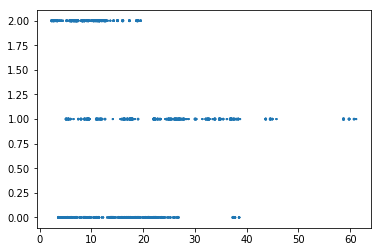

In [4]:
#dataset1

#Creating a scater plot
%matplotlib inline

#colormap=np.array(['Red','Blue','Green'])

z0=plt.scatter(finalp.pte_value,finalp.Sex_Index,finalp.TIME_Index) #x=pte,y=Sex and third parameter time

#Gives us 3 clusters on the basis of3input features

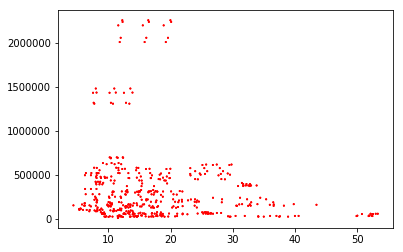

In [5]:

z1=plt.scatter(finalp.se_value,finalp.Cost,s=finalp.Impexp_Index,c="Red") #x=se,y=Cost and Impexp index as s

#We can clearly see 3 clusters, and by seeing data it can be assumed that
#most resides at position with low self employment rate and low export cost

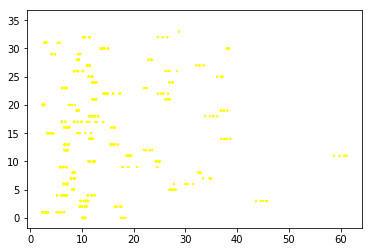

In [7]:
z2=plt.scatter(finalp.pte_value,finalp.Country_Index,s=finalp.Sex_Index,c="Yellow") #x=pte,y=Country
                                                                                     #and time is given to s
    
    #shows that part-time employment rate mostly is less than 30 % in most countries

In [10]:
#dataset2
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
## dataset2-final2

finalp2=pd.read_csv('fi2.csv/fin2')
#Assigning number of clusters
b=KMeans(n_clusters=3) #creating 3 clusters
b.fit(finalp2)
b.labels_




array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 0, 0],
      dtype=int32)

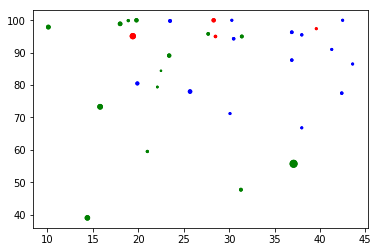

In [17]:


#Creating a scater plot
%matplotlib inline
finalp2=pd.read_csv('fi2.csv/fin2')
y=finalp2['Population with Secondary Education (Female)']                      
x=finalp2['Percent Representation in Parliament']
z=finalp2['Maternal Mortality Ratio']

colormap=np.array(['Red','Blue','Green'])

z3= plt.scatter (x,y,z,c=colormap[b.labels_])

#clearly shows that with high education level in female, the % in parliament stays between 10-45%



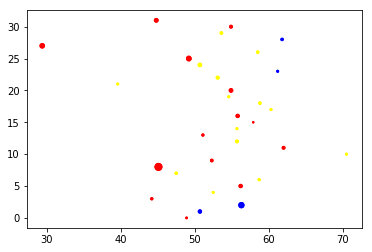

In [16]:
z=finalp2['Maternal Mortality Ratio']
y=finalp2['Country_Index']
x=finalp2['Labour Force Participation Rate (Female)']
#w=finalp2['Sex_Index']
colormap=np.array(['BLUE','Yellow','red'])

z3= plt.scatter (x,y,z,c=colormap[b.labels_])

#the average labour force participation of female is between 45-60%

#### notice the xaxis scale

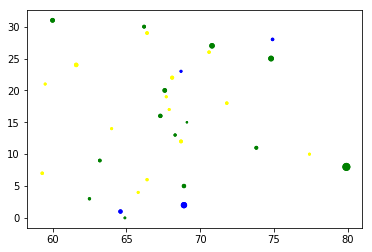

In [15]:
z=finalp2['Maternal Mortality Ratio']
y=finalp2['Country_Index']
x=finalp2['Labour Force Participation Rate (Male)']
#w=finalp2['Sex_Index']
colormap=np.array(['BLUE','Yellow','GREEN'])

z3= plt.scatter (x,y,z,c=colormap[b.labels_])

#the average labour force participation of male is between 65-72%

### notice the x axis scale


In [211]:
#Algorithm BisectingKMEANS

#Dataset1
from pyspark.ml.clustering import BisectingKMeans


# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1) #for 2 clusters
model = bkm.fit(final1_data)

# Evaluate clustering.
cost = model.computeCost(final1_data)
print("\nWithin Set Sum of Squared Errors = " + str(cost))

# Shows the result.
print("\nCluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)



Within Set Sum of Squared Errors = 2408633023313541.5

Cluster Centers: 
[6.27045541e+05 5.00000000e-01 9.65921193e-01 1.90202343e+00
 2.97181177e+05 1.67586581e+01 1.78723323e+01 1.57965921e+01]
[1.97200000e+07 5.00000000e-01 1.00000000e+00 2.00000000e+00
 2.08680300e+06 1.76613333e+01 1.58746667e+01 5.00000000e+00]


In [212]:
#Dataset2
from pyspark.ml.clustering import BisectingKMeans


# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(4).setSeed(1) #for 4 clusters
model = bkm.fit(final2_data)

# Evaluate clustering.
cost = model.computeCost(final2_data)
print("\nWithin Set Sum of Squared Errors = " + str(cost))

# Shows the result.
print("\nCluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)


Within Set Sum of Squared Errors = 2346621755.6898403

Cluster Centers: 
[2.80931429e+04 1.55927143e+04 5.00000000e-01 6.28071429e+01
 1.97857143e+01 7.19571429e+01 7.81714286e+01 1.62857143e+01
 4.52142857e+01 6.86428571e+01]
[3.64594444e+04 2.29870000e+04 5.00000000e-01 6.43166667e+01
 2.70111111e+01 8.33222222e+01 8.62666667e+01 1.37777778e+01
 5.35888889e+01 6.69000000e+01]
[5.16308333e+04 3.28205000e+04 5.00000000e-01 6.40375000e+01
 3.42916667e+01 9.05916667e+01 9.18500000e+01 1.70000000e+01
 5.64750000e+01 6.74916667e+01]
[7.07730e+04 4.91115e+04 5.00000e-01 6.51625e+01 2.89500e+01 9.68750e+01
 9.70250e+01 1.35000e+01 5.75000e+01 6.92750e+01]
